### Installing all the required Packages

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import json
import re
from urllib.parse import urljoin
from gensim import corpora
from gensim.models import LdaModel
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from wordcloud import WordCloud

### Scrapping data from the main site of Honda and also from its other-links mentioned in the main website

### Also stored the file in a json format for topic modelling to be performed later.


In [20]:
def scrape_page(url):
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
        content = soup.get_text(separator=' ', strip=True)
        sentences = [sentence.strip() for sentence in content.split('.') if sentence.strip()]
        return sentences
    except Exception as e:
        print(f"Error scraping {url}: {str(e)}")
        return []

def scrape_honda_website():
    base_url = "https://global.honda/en/"
    scraped_data = {}
    
    # Scrape main page
    scraped_data[base_url] = scrape_page(base_url)
    
    # Find co-links on the front page
    response = requests.get(base_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    links = soup.find_all('a', href=True)
    
    for link in links:
        url = urljoin(base_url, link['href'])
        if url.startswith(base_url) and url not in scraped_data:
            scraped_data[url] = scrape_page(url)
    
    return scraped_data

# Scrape Honda website and its co-links
honda_data = scrape_honda_website()

# Save data to JSON file
with open('honda_data.json', 'w', encoding='utf-8') as f:
    json.dump(honda_data, f, ensure_ascii=False, indent=4)

print("Scraping completed and data saved to honda_data.json")


Scraping completed and data saved to honda_data.json


### Topic Modelling and WordCloud

Top 5 Topics:
Topic 0: 0.038*"honda" + 0.015*"seconds" + 0.014*"passion" + 0.013*"dreams" + 0.012*"mobility" + 0.012*"joy" + 0.009*"corporate" + 0.007*"business" + 0.007*"people" + 0.007*"player"
Topic 1: 0.089*"honda" + 0.021*"power" + 0.018*"dreams" + 0.017*"corporate" + 0.011*"global" + 0.010*"world" + 0.010*"mobility" + 0.009*"motor" + 0.007*"brand" + 0.006*"philosophy"
Topic 2: 0.021*"honda" + 0.010*"reserved" + 0.010*"rights" + 0.010*"march" + 0.010*"global" + 0.008*"corporate" + 0.008*"brand" + 0.008*"slogan" + 0.008*"hondaâ" + 0.007*"year"
Topic 3: 0.024*"honda" + 0.013*"world" + 0.010*"financial" + 0.009*"mobility" + 0.008*"people" + 0.008*"transcend" + 0.008*"racing" + 0.008*"technologies" + 0.007*"championships" + 0.007*"ir"
Topic 4: 0.042*"honda" + 0.010*"subsidiaries" + 0.010*"read" + 0.010*"affiliates" + 0.009*"investor" + 0.009*"driver" + 0.008*"team" + 0.008*"power" + 0.007*"mobility" + 0.007*"leader"


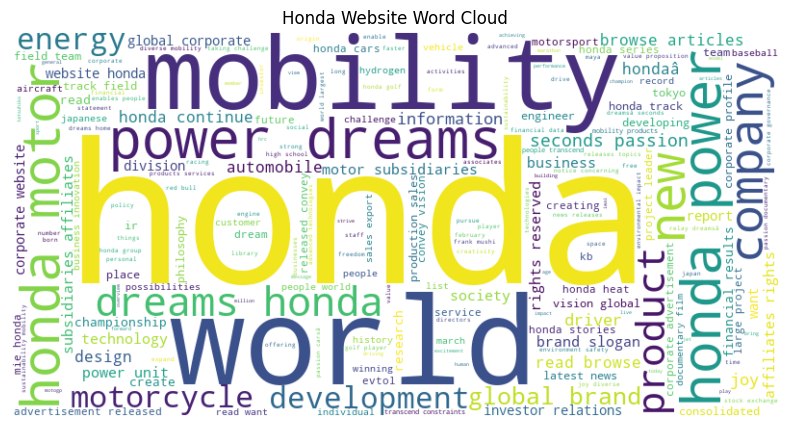

In [21]:
# Load the scraped data
with open('honda_data.json', 'r', encoding='utf-8') as f:
    honda_data = json.load(f)

# Prepare the documents for topic modeling
documents = []
for url, sentences in honda_data.items():
    documents.extend(sentences)

# Preprocess the documents
def preprocess(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

processed_docs = [preprocess(doc) for doc in documents]

# Create a dictionary and corpus for topic modeling
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Perform topic modeling using LDA
num_topics = 5
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)

# Print the topics
print("Top 5 Topics:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# Generate word cloud
all_words = ' '.join([' '.join(doc) for doc in processed_docs])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Honda Website Word Cloud')
plt.show()


In [23]:
from sklearn.manifold import TSNE
from matplotlib.gridspec import GridSpec

### Performing Individual topic wordclouds and showing out Inter-topic distance visualisation

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 307 samples in 0.000s...
[t-SNE] Computed neighbors for 307 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 307 / 307
[t-SNE] Mean sigma: 0.021407
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.755619
[t-SNE] KL divergence after 1000 iterations: 0.070704

Top Keywords for Each Topic:
Topic 0: 0.038*"honda" + 0.015*"seconds" + 0.014*"passion" + 0.013*"dreams" + 0.012*"mobility" + 0.012*"joy" + 0.009*"corporate" + 0.007*"business" + 0.007*"people" + 0.007*"player"
Topic 1: 0.089*"honda" + 0.021*"power" + 0.018*"dreams" + 0.017*"corporate" + 0.011*"global" + 0.010*"world" + 0.010*"mobility" + 0.009*"motor" + 0.007*"brand" + 0.006*"philosophy"
Topic 2: 0.021*"honda" + 0.010*"reserved" + 0.010*"rights" + 0.010*"march" + 0.010*"global" + 0.008*"corporate" + 0.008*"brand" + 0.008*"slogan" + 0.008*"hondaâ" + 0.007*"year"
Topic 3: 0.024*"honda" + 0.013*"world" + 0.010*"financial" + 0.009

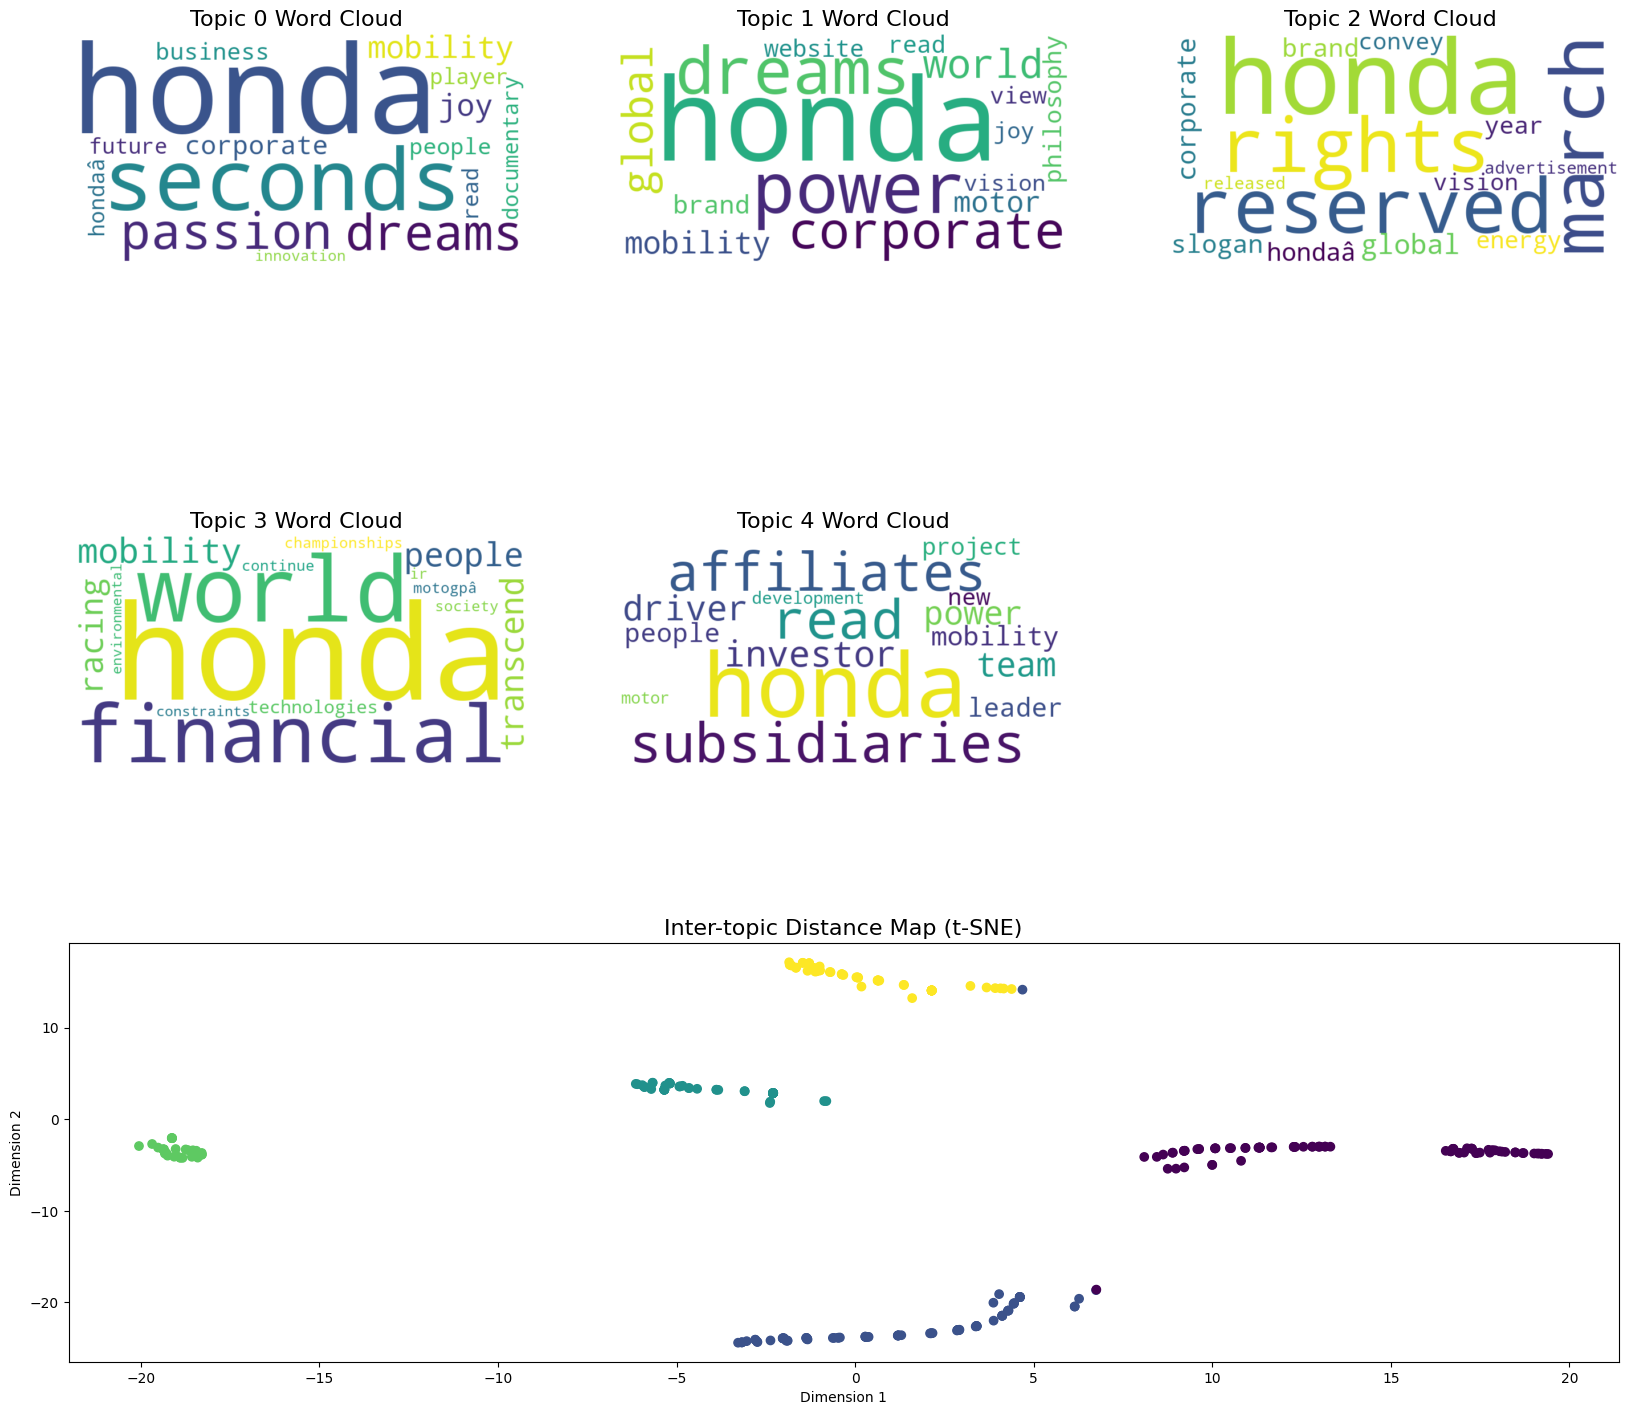

In [25]:
# Load the scraped data
try:
    with open('honda_data.json', 'r', encoding='utf-8') as f:
        honda_data = json.load(f)
except FileNotFoundError:
    # For demonstration, create sample data if file doesn't exist
    print("honda_data.json not found. Creating sample data for demonstration.")
    honda_data = {
        "url1": ["Honda is a global automobile manufacturer", "They produce cars, motorcycles, and power equipment"],
        "url2": ["Honda's commitment to innovation drives their success", "Sustainability is a key focus for Honda"]
    }

# Prepare the documents for topic modeling
documents = []
for url, sentences in honda_data.items():
    documents.extend(sentences)

# Preprocess the documents
def preprocess(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

processed_docs = [preprocess(doc) for doc in documents]

# Create a dictionary and corpus for topic modeling
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Perform topic modeling using LDA
num_topics = 5
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)

# Create a figure with a grid layout for our dashboard
plt.figure(figsize=(20, 25))
gs = GridSpec(4, 3, figure=plt.gcf())

# 1. Generate word clouds for each topic
for idx, topic in lda_model.show_topics(formatted=False, num_words=15):
    topic_words = dict(topic)
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white').generate_from_frequencies(topic_words)
    
    ax = plt.subplot(gs[idx // 3, idx % 3])
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Topic {idx} Word Cloud', fontsize=16)
    ax.axis('off')

# 2. Create inter-topic distance map using t-SNE
topic_weights = []
for i, doc_topics in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in doc_topics])

# Array of topic weights
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic for each document
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
ax = plt.subplot(gs[2, :])
ax.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], c=topic_num, cmap='viridis')
ax.set_title('Inter-topic Distance Map (t-SNE)', fontsize=16)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')

# 3. Topic Similarities Heatmap
topic_similarities = np.zeros((num_topics, num_topics))
for i in range(num_topics):
    for j in range(num_topics):
        # Calculate cosine similarity between topic vectors
        vec1 = dict(lda_model.show_topic(i, 50))
        vec2 = dict(lda_model.show_topic(j, 50))
        
        # Find common words
        common_words = set(vec1.keys()) & set(vec2.keys())
        
        # Calculate similarity
        if common_words:
            similarity = sum(vec1[word] * vec2[word] for word in common_words)
            topic_similarities[i, j] = similarity


# 4. Print topic keywords and probabilities
print("\nTop Keywords for Each Topic:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

print("\nTopic Probabilities for Sample Documents:")
topic_probabilities = lda_model.get_document_topics(corpus, minimum_probability=0.0)
for doc_idx, doc_probs in enumerate(topic_probabilities[:5]):  # Displaying for first 5 documents
    print(f"Document {doc_idx + 1}:")
    for topic_id, prob in sorted(doc_probs, key=lambda x: x[1], reverse=True):
        print(f"  Topic {topic_id}: {prob:.4f}")

### Now we will perorm Topic Modelling on Sustainability report of Honda

In [30]:
import nltk
from PyPDF2 import PdfReader
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
from gensim.models import CoherenceModel

In [31]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the sustainability report
file_path = 'Honda_Report_2024-en-all.pdf'  # Replace with the actual file name

# Extract text from the PDF
reader = PdfReader(file_path)
text = ''
for page in reader.pages:
    page_text = page.extract_text()
    if page_text:  # Check if text was extracted successfully
        text += page_text

# Tokenize text into sentences
sentences = sent_tokenize(text)

# Create a DataFrame to store the sentences
data = pd.DataFrame({'sentence': sentences})

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 3]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return tokens

# Apply preprocessing to each sentence
data['tokens'] = data['sentence'].apply(preprocess_text)

# Remove empty lists (sentences that contained only stopwords or non-alphabetic characters)
data = data[data['tokens'].map(len) > 0]

# Create a list of token lists for topic modeling
processed_docs = data['tokens'].tolist()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Samrat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Samrat\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Samrat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 1. Now we will perform LDA 
### 2. Then we will find the Optimal number of Topics

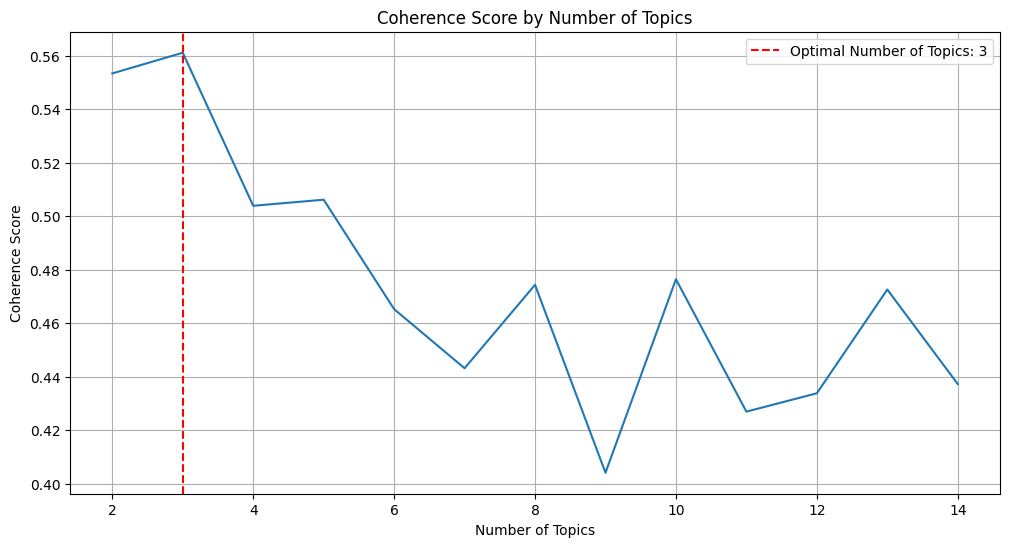

Optimal number of topics: 3
Coherence score: 0.5611


In [32]:
# Create a dictionary and corpus for topic modeling
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Function to compute coherence score for different numbers of topics
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=15, step=1):
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit, step):
        # Train LDA model
        model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, 
                               random_state=42, passes=10)
        model_list.append(model)
        
        # Calculate coherence score
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    
    return model_list, coherence_values

# Compute coherence scores for different numbers of topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, 
                                                       texts=processed_docs, start=2, limit=15, step=1)

# Find the optimal number of topics
optimal_num_topics = range(2, 15, 1)[coherence_values.index(max(coherence_values))]

# Plot coherence scores
plt.figure(figsize=(12, 6))
plt.plot(range(2, 15, 1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score by Number of Topics")
plt.axvline(x=optimal_num_topics, color='r', linestyle='--', 
           label=f'Optimal Number of Topics: {optimal_num_topics}')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal number of topics: {optimal_num_topics}")
print(f"Coherence score: {max(coherence_values):.4f}")

# Train the final LDA model with the optimal number of topics
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=optimal_num_topics, 
                           random_state=42, passes=10)

### Topics Worldcloud Generation

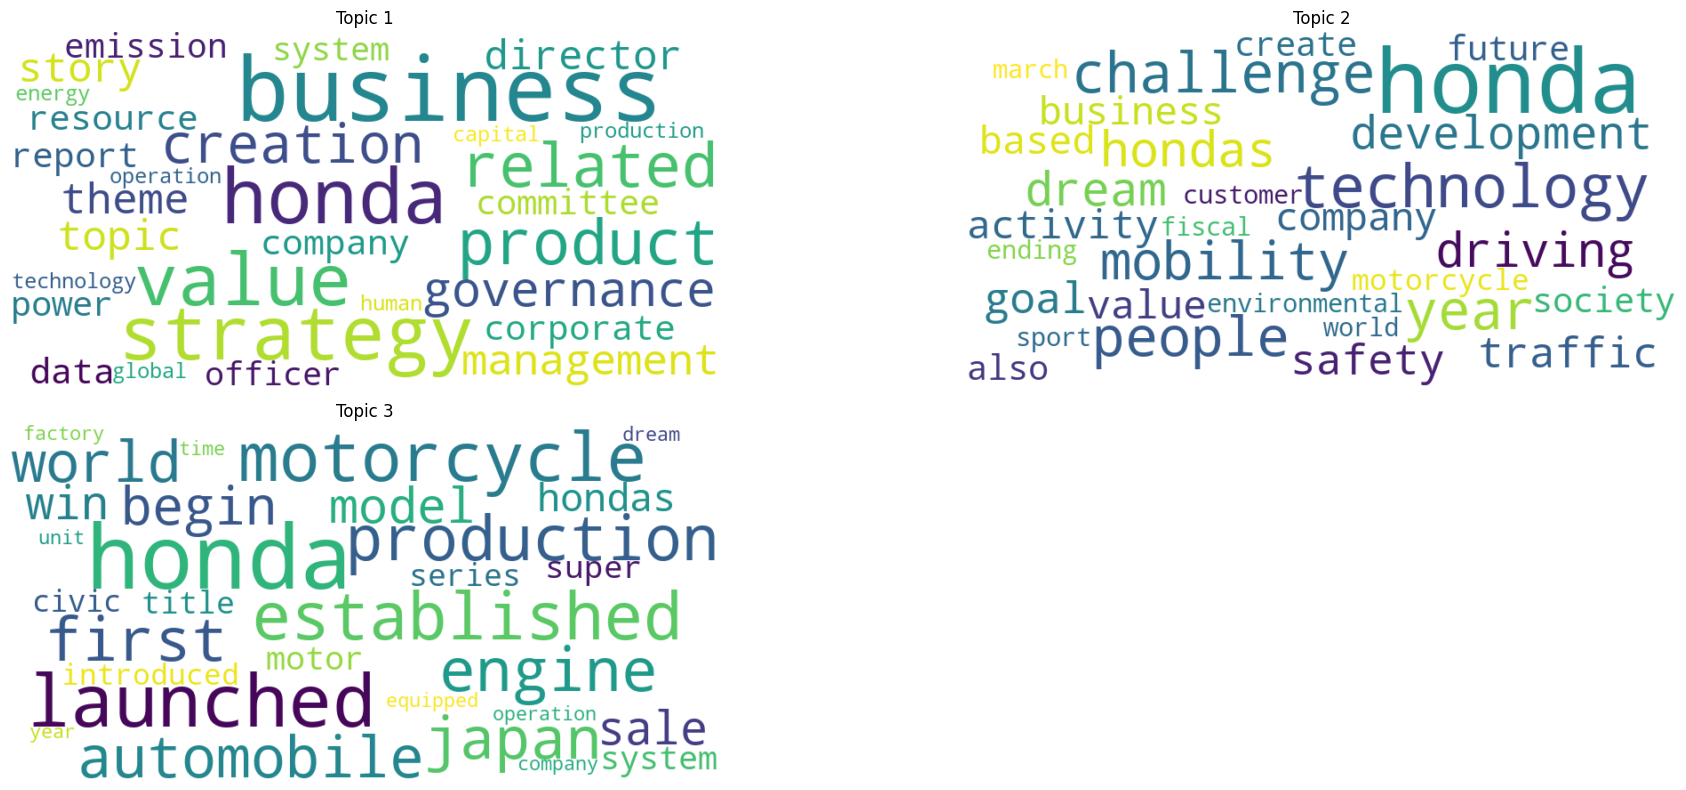


Top Words for Each Topic:
Topic 1: 0.019*"business" + 0.013*"honda" + 0.013*"strategy" + 0.012*"value" + 0.009*"product" + 0.008*"related" + 0.008*"creation" + 0.008*"governance" + 0.008*"management" + 0.008*"theme"
Topic 2: 0.024*"honda" + 0.008*"technology" + 0.007*"challenge" + 0.007*"people" + 0.007*"year" + 0.006*"mobility" + 0.005*"hondas" + 0.005*"driving" + 0.005*"dream" + 0.005*"development"
Topic 3: 0.026*"honda" + 0.017*"launched" + 0.014*"motorcycle" + 0.014*"established" + 0.012*"production" + 0.012*"engine" + 0.011*"first" + 0.011*"japan" + 0.010*"automobile" + 0.010*"world"


In [33]:
# Create a figure for word clouds
plt.figure(figsize=(20, 4 * ((optimal_num_topics + 1) // 2)))

# Generate word clouds for each topic
for t in range(optimal_num_topics):
    # Get the top words for the topic
    topic_words = dict(lda_model.show_topic(t, 30))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         colormap='viridis', max_font_size=100, 
                         prefer_horizontal=1.0).generate_from_frequencies(topic_words)
    
    # Plot the word cloud
    plt.subplot(((optimal_num_topics + 1) // 2), 2, t + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {t+1}')

plt.tight_layout()
plt.show()

# Print the top words for each topic
print("\nTop Words for Each Topic:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")


### Now we show the similiarity of Honda with Industry 5.0 Norms.

### For this we have taken keyword analysis as best approach. 

Topic 1: business, honda, strategy, value, product, related, creation, governance, management, theme
Topic 2: honda, technology, challenge, people, year, mobility, hondas, driving, dream, development
Topic 3: honda, launched, motorcycle, established, production, engine, first, japan, automobile, world
Similarity between Industry 5.0 and Topic 1: 0.1378
Similarity between Industry 5.0 and Topic 2: 0.0372
Similarity between Industry 5.0 and Topic 3: 0.0277


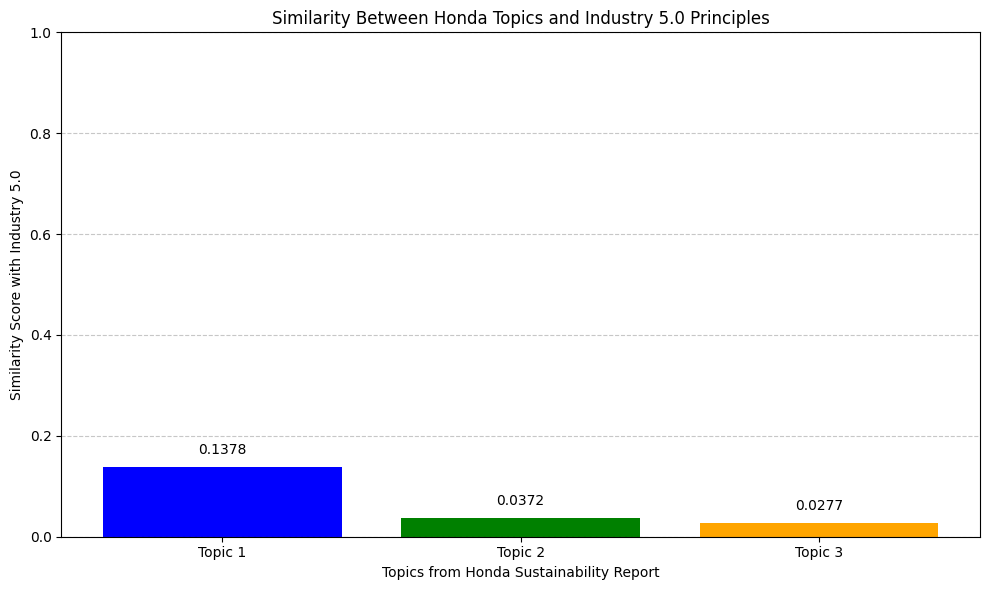


Overall Industry 5.0 Alignment Score: 0.0676
Honda shows limited alignment with Industry 5.0 principles


In [41]:
# Assuming lda_model is already defined from your previous code
# Let's extract the topics first
honda_topics = [
    dict(lda_model.show_topic(0, 30)),  # Topic 1
    dict(lda_model.show_topic(1, 30)),  # Topic 2
    dict(lda_model.show_topic(2, 30))   # Topic 3
]

# Convert the topics to a more readable format for display
topic_words = {}
for i, topic in enumerate(honda_topics):
    topic_words[i] = [word for word, _ in sorted(topic.items(), key=lambda x: x[1], reverse=True)]

# Print the top words in each topic
for i, words in topic_words.items():
    print(f"Topic {i+1}: {', '.join(words[:10])}")

# Now let's calculate the similarity with Industry 5.0 keywords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Keywords relevant for Industry 5.0
industry_5_0_keywords = [
    "human-centric", "sustainability", "resilience", "collaborative robots", "COBOTs",
    "artificial intelligence", "AI", "big data", "IoT", "Internet of Things",
    "cloud computing", "automation", "personalization", "mass customization",
    "mass personalization", "digital twins", "smart factories", "cybersecurity",
    "data analytics", "machine learning", "robotics", "edge computing", "6G",
    "genAI", "augmented reality", "virtual reality", "predictive maintenance",
    "energy efficiency", "circular economy", "green manufacturing",
    "worker empowerment", "custom manufacturing", "intelligent systems",
    "connected devices", "real-time data", "human-machine collaboration",
    "eco-friendly", "precision manufacturing", "quality control",
    "supply chain resilience", "smart sensors", "digital transformation",
    "value-driven", "technology interface", "design thinking", "creativity",
    "innovation", "smart production", "sustainable production", "tailored solutions",
    "customer satisfaction", "environmental impact", "resource preservation",
    "climate change", "social stability", "energy harvesting", "data-driven insights",
    "operational excellence", "adaptive systems", "flexibility", "agility",
    "worker safety", "human creativity", "critical thinking", "intelligent automation",
    "bespoke services", "customized products", "smart manufacturing",
    "advanced technologies", "digital knowledge", "distributed intelligence",
    "legacy information", "personal devices", "secure AI", "localized AI",
    "human well-being", "worker-centric", "production limits", "prosperity",
    "societal goals", "economic growth", "human progress", "regenerative economy",
    "equitable prosperity", "transformative growth", "sustainable value",
    "circular production", "regenerative purpose", "technological transformation",
    "industrial production", "smart systems", "data-centric", "virtual revolution",
    "extractive economy", "consumption-driven", "social value", "welfare",
    "human-centered design", "collaborative innovation", "ethical AI",
    "responsible manufacturing", "decarbonization", "resource efficiency", "zero waste"
]

# Convert topics and keywords into strings for vectorization
industry_5_0_text = ' '.join(industry_5_0_keywords)
honda_topics_text = [' '.join(list(topic.keys())) for topic in honda_topics]

# Combine all text for vectorization
all_texts = [industry_5_0_text] + honda_topics_text

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Compute cosine similarity between Industry 5.0 keywords and each topic
similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()

# Output the similarity scores
for i, similarity in enumerate(similarities):
    print(f"Similarity between Industry 5.0 and Topic {i+1}: {similarity:.4f}")

# Visualize the similarity scores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(['Topic 1', 'Topic 2', 'Topic 3'], similarities, color=['blue', 'green', 'orange'])
plt.xlabel('Topics from Honda Sustainability Report')
plt.ylabel('Similarity Score with Industry 5.0')
plt.title('Similarity Between Honda Topics and Industry 5.0 Principles')
plt.ylim(0, 1)  # Cosine similarity ranges from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the similarity values on top of each bar
for i, v in enumerate(similarities):
    plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Calculate the average similarity to get an overall score
average_similarity = similarities.mean()
print(f"\nOverall Industry 5.0 Alignment Score: {average_similarity:.4f}")

# Interpret the results
if average_similarity > 0.7:
    interpretation = "Honda shows strong alignment with Industry 5.0 principles"
elif average_similarity > 0.5:
    interpretation = "Honda shows moderate alignment with Industry 5.0 principles"
elif average_similarity > 0.3:
    interpretation = "Honda shows some alignment with Industry 5.0 principles"
else:
    interpretation = "Honda shows limited alignment with Industry 5.0 principles"

print(interpretation)


### Detailed Analysis of Topic-Keyword Overlap

In [42]:
# Flatten the topic words into sets for easier comparison
topic_word_sets = [set(words) for words in topic_words.values()]
industry_5_0_keyword_set = set([keyword.lower() for keyword in industry_5_0_keywords])

# Find overlapping keywords for each topic
for i, topic_set in enumerate(topic_word_sets):
    overlap = topic_set.intersection(industry_5_0_keyword_set)
    print(f"\nIndustry 5.0 keywords present in Topic {i+1}:")
    if overlap:
        print(", ".join(overlap))
    else:
        print("No direct keyword matches found")
    
    # Find semantically similar words (words that might be related but not exact matches)
    # This is a simplified approach - for more accurate results, you could use word embeddings
    related_words = []
    for word in topic_set:
        for keyword in industry_5_0_keyword_set:
            # Check if the word is a substring of any keyword or vice versa
            if word in keyword or keyword in word:
                if word != keyword and word not in overlap:
                    related_words.append(f"{word} (related to {keyword})")
    
    if related_words:
        print("\nSemanticaly related words:")
        print(", ".join(related_words[:10]))  # Limit to 10 to avoid too much output



Industry 5.0 keywords present in Topic 1:
No direct keyword matches found

Semanticaly related words:
value (related to social value), value (related to value-driven), value (related to sustainable value), resource (related to resource preservation), resource (related to resource efficiency), data (related to data analytics), data (related to data-driven insights), data (related to real-time data), data (related to big data), data (related to data-centric)

Industry 5.0 keywords present in Topic 2:
No direct keyword matches found

Semanticaly related words:
value (related to social value), value (related to value-driven), value (related to sustainable value), goal (related to societal goals), environmental (related to environmental impact), technology (related to technology interface), safety (related to worker safety), customer (related to customer satisfaction)

Industry 5.0 keywords present in Topic 3:
No direct keyword matches found

Semanticaly related words:
time (related to rea

### Radar Chart Visualization

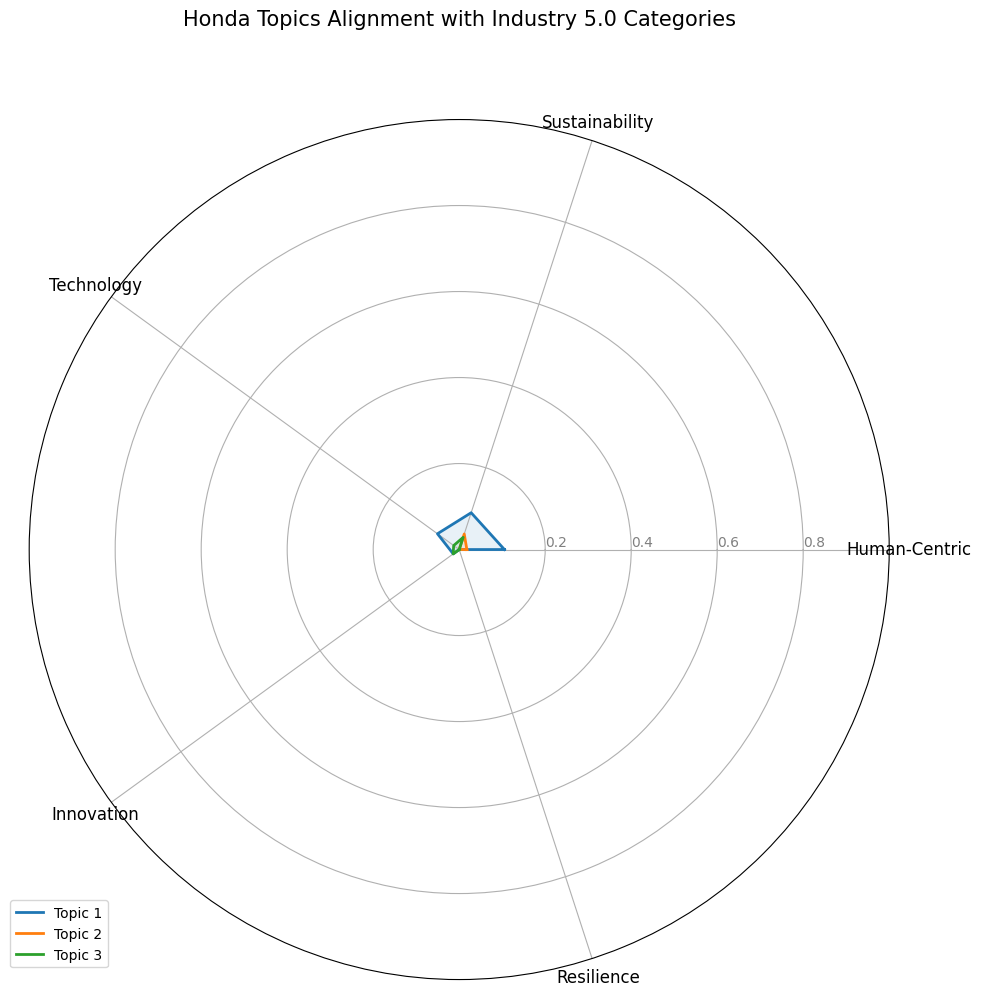

In [43]:
# Group Industry 5.0 keywords into categories
industry_5_0_categories = {
    "Human-Centric": ["human-centric", "worker empowerment", "human-machine collaboration", 
                     "worker safety", "human creativity", "critical thinking", "human well-being", 
                     "worker-centric", "human progress", "human-centered design", "welfare"],
    
    "Sustainability": ["sustainability", "eco-friendly", "environmental impact", "resource preservation", 
                      "climate change", "sustainable production", "sustainable value", "circular production", 
                      "regenerative purpose", "circular economy", "green manufacturing", "decarbonization", 
                      "resource efficiency", "zero waste"],
    
    "Technology": ["artificial intelligence", "AI", "big data", "IoT", "Internet of Things", 
                  "cloud computing", "automation", "digital twins", "smart factories", "cybersecurity", 
                  "data analytics", "machine learning", "robotics", "edge computing", "6G", "genAI", 
                  "augmented reality", "virtual reality", "smart sensors", "intelligent systems", 
                  "connected devices", "real-time data", "smart systems", "data-centric"],
    
    "Innovation": ["innovation", "design thinking", "creativity", "smart production", 
                  "operational excellence", "adaptive systems", "flexibility", "agility", 
                  "intelligent automation", "advanced technologies", "technological transformation", 
                  "collaborative innovation"],
    
    "Resilience": ["resilience", "supply chain resilience", "social stability", 
                  "transformative growth", "economic growth", "prosperity", "equitable prosperity"]
}

# Calculate similarity for each category
category_similarities = {}
for category, keywords in industry_5_0_categories.items():
    category_text = ' '.join(keywords)
    all_texts = [category_text] + honda_topics_text
    
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    
    category_sims = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()
    category_similarities[category] = category_sims

# Create a radar chart
import numpy as np
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

def radar_chart(categories, values, title):
    # Number of variables
    N = len(categories)
    
    # What will be the angle of each axis in the plot (divide the plot / number of variables)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], categories, size=12)
    
    # Draw the y-axis labels (0 to 1 for similarity scores)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="grey", size=10)
    plt.ylim(0, 1)
    
    # Plot each topic
    for i in range(3):
        values_topic = [category_similarities[cat][i] for cat in categories]
        values_topic += values_topic[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, values_topic, linewidth=2, linestyle='solid', label=f'Topic {i+1}')
        ax.fill(angles, values_topic, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    # Add title
    plt.title(title, size=15, y=1.1)
    
    return fig, ax

# Create the radar chart
categories = list(industry_5_0_categories.keys())
fig, ax = radar_chart(categories, None, 'Honda Topics Alignment with Industry 5.0 Categories')
plt.tight_layout()
plt.show()
